# Data analysis of Ames dataset

In [37]:
import os
import sys
import pyrootutils

pyrootutils.setup_root(os.path.abspath(''), indicator=".project-root", pythonpath=True)
sys.path.append('..')
sys.path.append('')


In [33]:
import itertools
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib.figure import Figure
from rdkit import Chem
from torch import Tensor


Model files:

In [34]:
MODELS = [
    "encoder_only_C2C", "encoder_only_R2C", "encoder_only_E2C",
    "encoder_only_MC2C", "encoder_only_MR2C", "encoder_only_ME2C",
    "encoder_decoder_C2C", "encoder_decoder_R2C", "encoder_decoder_E2C",
    "encoder_decoder_MC2C", "encoder_decoder_MR2C", "encoder_decoder_ME2C",
    "native", "untrained",
    "encoder_decoder_ME2C_256", "encoder_decoder_ME2C_128", "encoder_decoder_ME2C_64",
    "encoder_decoder_ME2C_0_1", "encoder_decoder_ME2C_0_2", "encoder_decoder_ME2C_0_5",
    "encoder_decoder_ME2C_random", "encoder_decoder_ME2C_cnn", "encoder_decoder_ME2C_enum",
]
METHODS=["ig", "shap","attention_maps", "rollout", "grad", "att_grad", "cat", "att_cat"]
SECTIONS=["full", "canon", "random", "no_canon"]

name_mapper = {
    "encoder_only_C2C": "C2C",
    "encoder_only_R2C": "R2C",
    "encoder_only_E2C": "E2C",
    "encoder_only_MC2C": "MC2C",
    "encoder_only_MR2C": "MR2C",
    "encoder_only_ME2C": "ME2C",
    "encoder_decoder_C2C": "C2C",
    "encoder_decoder_R2C": "R2C",
    "encoder_decoder_E2C": "E2C",
    "encoder_decoder_MC2C": "MC2C",
    "encoder_decoder_MR2C": "MR2C",
    "encoder_decoder_ME2C": "ME2C",
    "native": "native",
    "untrained": "untrained",
    "encoder_decoder_ME2C_256": "256",
    "encoder_decoder_ME2C_128": "128",
    "encoder_decoder_ME2C_64": "64",
    "encoder_decoder_ME2C_0_1": "10%",
    "encoder_decoder_ME2C_0_2": "20%",
    "encoder_decoder_ME2C_0_5": "50%",
    "encoder_decoder_ME2C_train": "train",
    "encoder_decoder_ME2C_random": "random",
    "encoder_decoder_ME2C_cnn": "CNN",
    "encoder_decoder_ME2C_enum": "enumerated",
}


Root directory of project:

In [35]:
ROOT = str(pyrootutils.find_root())
FILES_FOLDER = "interpretation_files"


Load data:

In [36]:
from representation.src.analysis.importance import gather_batches
from representation.src.analysis.reorder import parse_data, parse_hits

alert_file = f"{ROOT}/data/updated_structural_alerts.csv"
data_file = f"{ROOT}/{FILES_FOLDER}/{MODELS[0]}/prediction_data.csv"
attribution_files = {f"{name}_{method}": f"{ROOT}/{FILES_FOLDER}/{name}/{method}.csv" for name in MODELS for method in METHODS}

max_rows = 14099
df = parse_data(pd.read_csv(data_file, nrows=max_rows), smiles_col="src")
df = parse_hits(df, smiles_col="src", alerts=pd.read_csv(alert_file))

train_df = pd.read_csv(f"{ROOT}/data/ames_scaffold_train.csv")
val_df = pd.read_csv(f"{ROOT}/data/ames_scaffold_valid.csv")
test_df = pd.read_csv(f"{ROOT}/data/ames_scaffold_test.csv")

train_df_random = pd.read_csv(f"{ROOT}/data/ames_random_train.csv")
val_df_random = pd.read_csv(f"{ROOT}/data/ames_random_valid.csv")
test_df_random = pd.read_csv(f"{ROOT}/data/ames_random_test.csv")


### Histogram of SMILES lengths

In [8]:
def plot_histograms(df: pd.DataFrame,
                    drug_column_name: Optional[str] = 'Drug',
                    label_column_name: Optional[str] = 'Y',
                    visualization_method: Optional[str] = 'dodge',
                    save_figure_path: Optional[str] = None,
                    ax: Optional[plt.Axes] = None,
                    title: Optional[str] = None,
                    ) -> Figure:
    """
    visualization_method can be "layer", "stack", "fill", "dodge"
    """

    # get lengths
    df['SMILES length'] = df[drug_column_name].apply(lambda x: len(x))

    # Rename label column
    df['Ames test result'] = df[label_column_name].map({1: 'Positive', 0: 'Negative'})

    # Initialize
    sns.set(style='whitegrid')
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    # Colors
    binary_palette = {'Negative': 'tab:blue', 'Positive': 'tab:orange'}

    # Sort the DataFrame so that 'Negative' is last (because of the way the plot is drawn)
    df = df.sort_values(by='Ames test result', ascending=True)

    # plot
    sns.histplot(data=df,
                 x='SMILES length',
                 hue='Ames test result',
                 multiple= visualization_method,
                 palette=binary_palette,
                 edgecolor='.3',
                 linewidth=.5,
                 ax=ax,
    )

    # save figure
    if save_figure_path is not None:
        fig.savefig(save_figure_path, format='pdf', bbox_inches='tight')

    # set title
    if title is not None:
        ax.set_title(title)

    return fig


Usage:

 You can either save them individually using the save_figure_path argument or you can create a composite figure that includes multiple subfigures (subplots) here directly. Also feel free to change the visualization_method argument if you are not happy with the way it is visualized :)

Save directly:

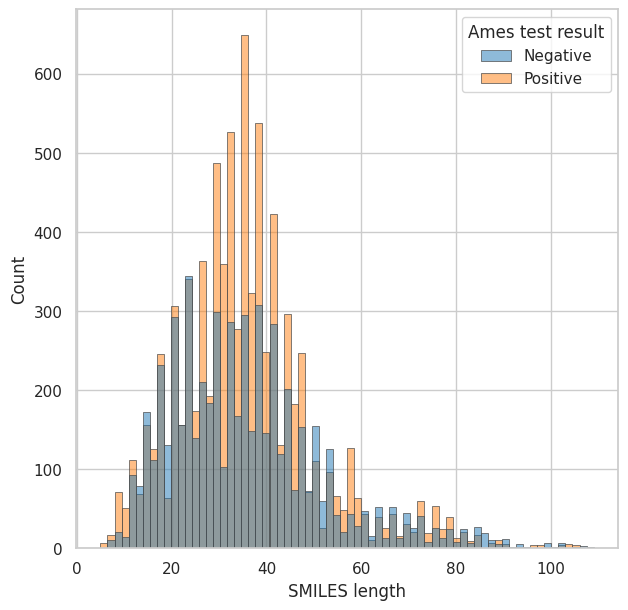

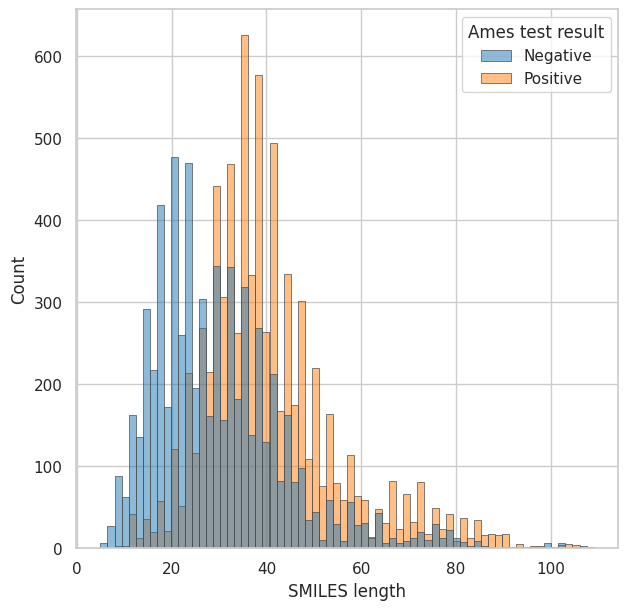

In [10]:
# set figure size
plt.rcParams['figure.figsize']= [7, 7]

fig1 = plot_histograms(df, drug_column_name="src", label_column_name="label", visualization_method='layer', save_figure_path=None)
fig1 = plot_histograms(df, drug_column_name="src", label_column_name="final_pred", visualization_method='layer', save_figure_path=None)
# fig1 = plot_histograms(train_df, visualization_method='layer', save_figure_path='Figures/ames_train_histogram.pdf')
# fig2 = plot_histograms(val_df, visualization_method='layer', save_figure_path='Figures/ames_val_histogram.pdf')
# fig3 = plot_histograms(test_df, visualization_method='layer', save_figure_path='Figures/ames_test_histogram.pdf')


Make a composite figure here:

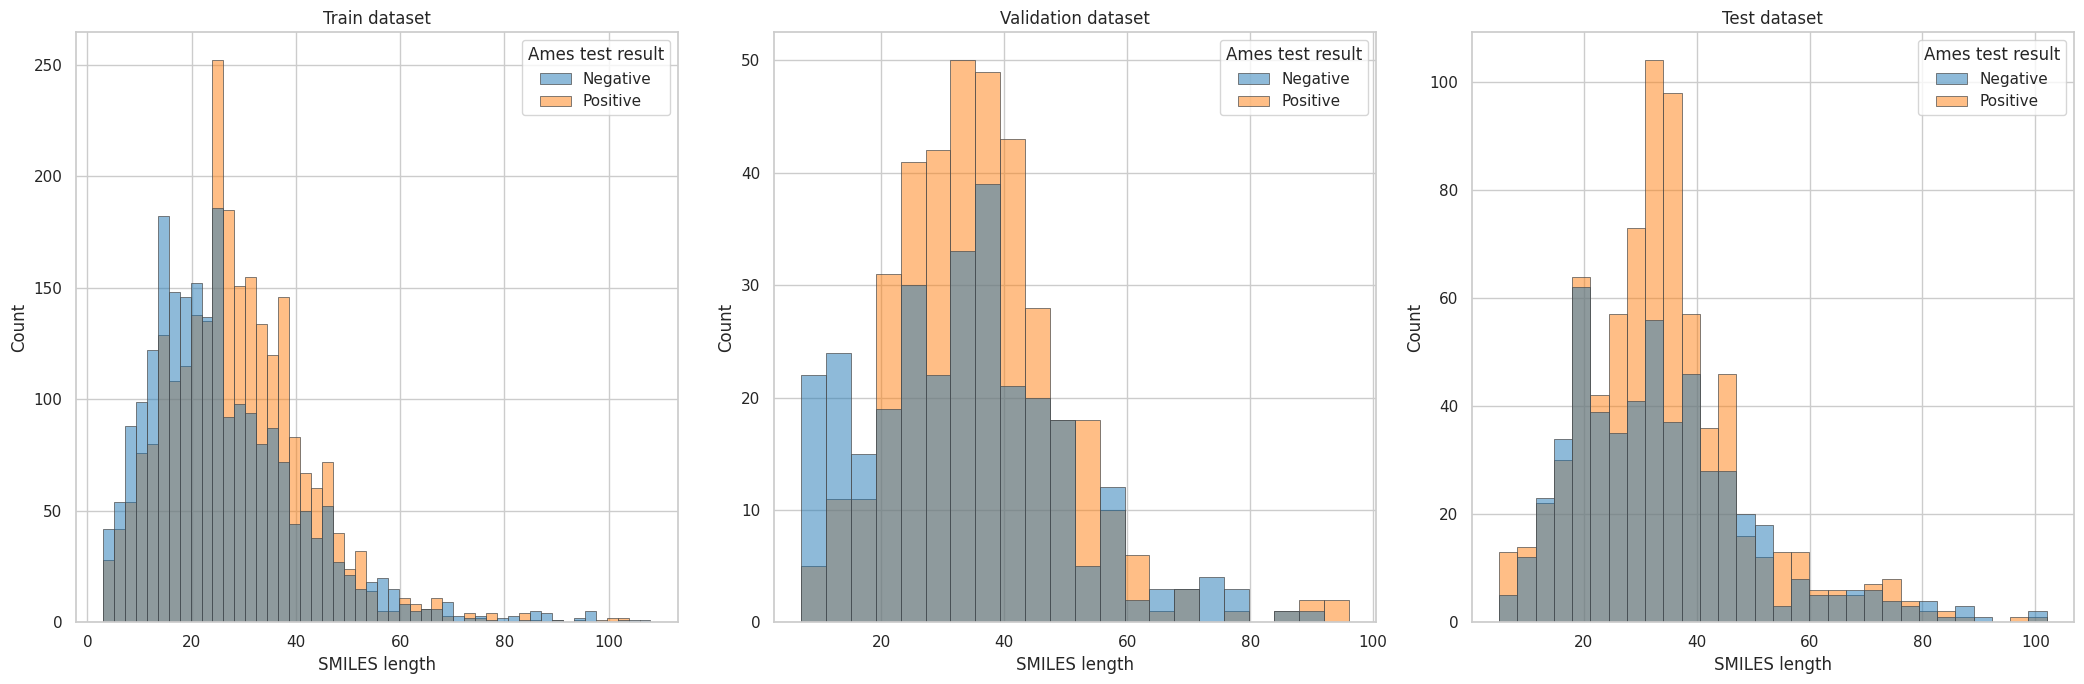

In [16]:
# Set figure size
plt.rcParams['figure.figsize'] = [21, 7]  # Width for 3 subfigures and height


fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# generate plots
plot_histograms(train_df, drug_column_name="canonical_smiles", visualization_method='layer', ax=axs[0], title='Train dataset')
plot_histograms(val_df, drug_column_name="canonical_smiles", visualization_method='layer', ax=axs[1], title='Validation dataset')
plot_histograms(test_df, drug_column_name="canonical_smiles", visualization_method='layer', ax=axs[2], title='Test dataset')

# Show
plt.tight_layout()
plt.show()

# save
# fig.savefig('Figures/composite.pdf', format='pdf', bbox_inches='tight')


### t-SNE:

In [11]:
from rdkit.Chem import AllChem
from sklearn.manifold import TSNE


Get Morgan fingerprints:

In [12]:
def get_morgan_fingerprint(smiles, radius: Optional[int] = 3, n_bits: Optional[int] = 1024):
    mol = Chem.MolFromSmiles(smiles)
    assert mol is not None, f'Could not parse SMILES: {smiles}'
    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits))


Plotting function:

In [40]:
def plot_tSNE(df: pd.DataFrame,
              drug_column_name: Optional[str] = 'Drug',
              label_column_name: Optional[str] = 'Y',
              save_figure_path: Optional[str] = None,
              ax: Optional[plt.Axes] = None,
              title: Optional[str] = None,
              ) -> Figure:

    # get fingerprints
    df['Fingerprint'] = df[drug_column_name].apply(get_morgan_fingerprint)
    fingerprint_arrays = np.array([x for x in df['Fingerprint']])

    # t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(fingerprint_arrays)

    tsne_df = pd.DataFrame(tsne_results, columns=['t-SNE Component 1', 't-SNE Component 2'])
    tsne_df['Ames test result'] = df[label_column_name]#.map({1: 'Positive', 0: 'Negative'})

    # Initialize
    sns.set(style='whitegrid')
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    # Colors
    binary_palette = {'Training': 'tab:blue', 'Validation': 'tab:orange', 'Test': 'tab:red'}

    # Sort the DataFrame so that 'Negative' is last (because of the way the plot is drawn)
    tsne_df = tsne_df.sort_values(by='Ames test result', ascending=True)

    # Plotting
    sns.scatterplot(
        x='t-SNE Component 1', y='t-SNE Component 2',
        hue='Ames test result',
        palette=binary_palette,
        data=tsne_df,
        legend="full",
        alpha=0.6,
        s = 20,
        ax=ax
    )

    # Set title
    if title is not None:
        ax.set_title(title)

    # Save figure
    if save_figure_path is not None:
        fig.savefig(save_figure_path, format='pdf', bbox_inches='tight')

    return fig


Can be used in the same way as the other plotting function :)

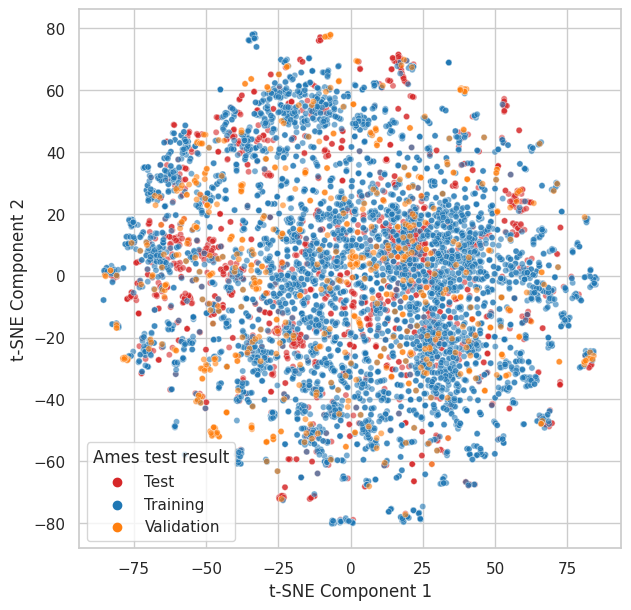

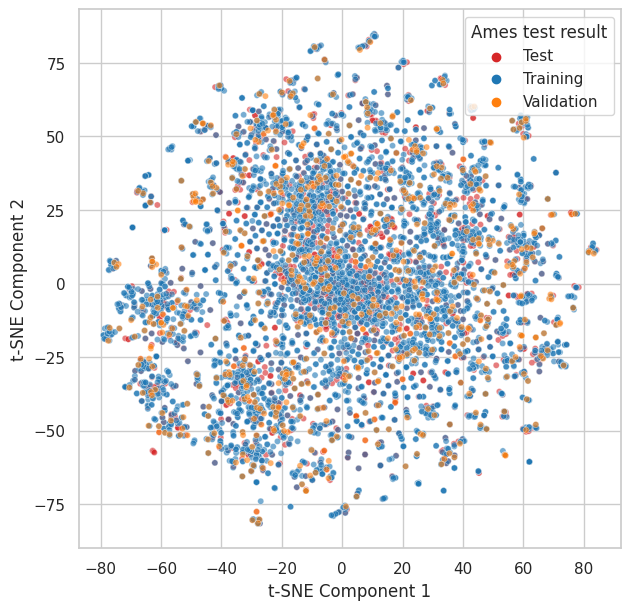

In [43]:
train_df_random["section"] = "Training"
val_df_random["section"] = "Validation"
test_df_random["section"] = "Test"

train_df["section"] = "Training"
val_df["section"] = "Validation"
test_df["section"] = "Test"

full_df = pd.concat([train_df, val_df, test_df]).reset_index()
full_df_random = pd.concat([train_df_random, val_df_random, test_df_random]).reset_index()

plt.rcParams['figure.figsize'] = [7, 7]
fig1 = plot_tSNE(full_df, drug_column_name="canonical_smiles", label_column_name="section", save_figure_path=None)
fig2 = plot_tSNE(full_df_random, drug_column_name="canonical_smiles", label_column_name="section", save_figure_path=None)


Composite Figure:

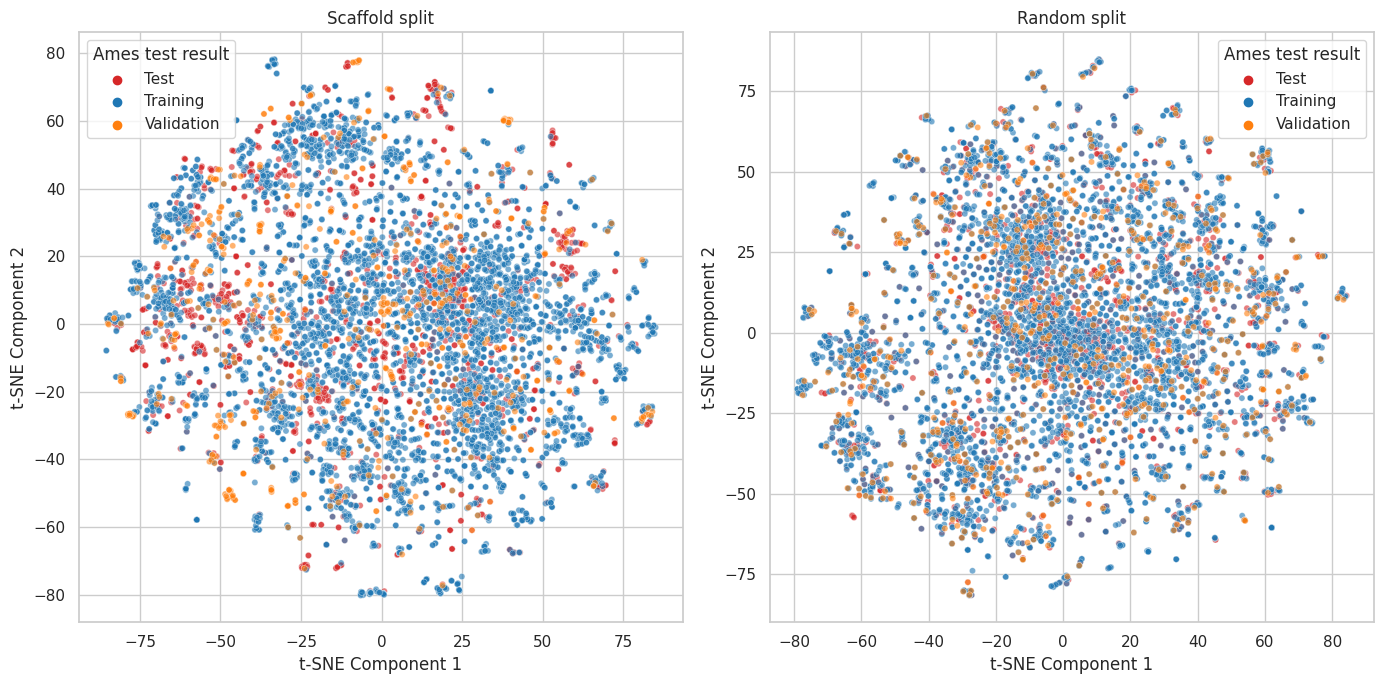

In [45]:
# Set figure size
plt.rcParams['figure.figsize'] = [14, 7]  # Width for 3 subfigures and height


fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# generate plots
plot_tSNE(full_df, drug_column_name="canonical_smiles", label_column_name="section", ax=axs[0], title='Scaffold split')
plot_tSNE(full_df_random, drug_column_name="canonical_smiles", label_column_name="section", ax=axs[1], title='Random split')

# Show
plt.tight_layout()
plt.show()

# save
# fig.savefig('Figures/tSNE.pdf', format='pdf', bbox_inches='tight')


### Amount of a specific element vs score

I came up with this count atoms function for the task (did not need something exactly like this before). I did some tests and it always worked but maybe there are some edge cases when it does not. Some tests are showcased

In [12]:
def count_atoms(smiles, atom_symbol):
    molecule = Chem.MolFromSmiles(smiles)
    return sum(1 for atom in molecule.GetAtoms() if atom.GetSymbol() == atom_symbol)


In [13]:
print(count_atoms('COCOCCl', 'C'))
print(count_atoms('COCOCCl', 'O'))
print(count_atoms('COCOCCl', 'Cl'))


3
2
1


Plotting function:

In [14]:
def plot_atom_number_vs_score(df: pd.DataFrame,
                              rdkit_atom_symbol: Optional[str] = 'C',
                              drug_column_name: Optional[str] = 'Drug',
                              score_column_name: Optional[str] = 'Score',
                              save_figure_path: Optional[str] = None,
                              ax: Optional[plt.Axes] = None,
                              title: Optional[str] = None,
                              errorbar: Optional[str] = 'sd',
                              drop_atom_numbers_that_only_occur_once: Optional[bool] = True,
                              ) -> Figure:

    """
    errorbar can be 'sd' or 'None' or some other fancy seaborn stuff
    drop_atom_numbers_that_only_occur_once: useful if you want errorbars for all points
    """

    # get element amounts
    x_column_name = f'Number of {rdkit_atom_symbol} atoms'
    df[x_column_name] = df[drug_column_name].apply(lambda x: count_atoms(x, rdkit_atom_symbol))

    # drop atom numbers that only occur once
    if drop_atom_numbers_that_only_occur_once:
        df = df.groupby(x_column_name).filter(lambda x: len(x) > 1)

    # Initialize
    sns.set(style='whitegrid')
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    # Plot
    sns.lineplot(data=df,
                 x=x_column_name,
                 y=score_column_name,
                 errorbar=errorbar,
                 ax=ax)
    # save figure
    if save_figure_path is not None:
        fig.savefig(save_figure_path, format='pdf', bbox_inches='tight')

    # set title
    if title is not None:
        ax.set_title(title)

    return fig


Code can be used the same way as before

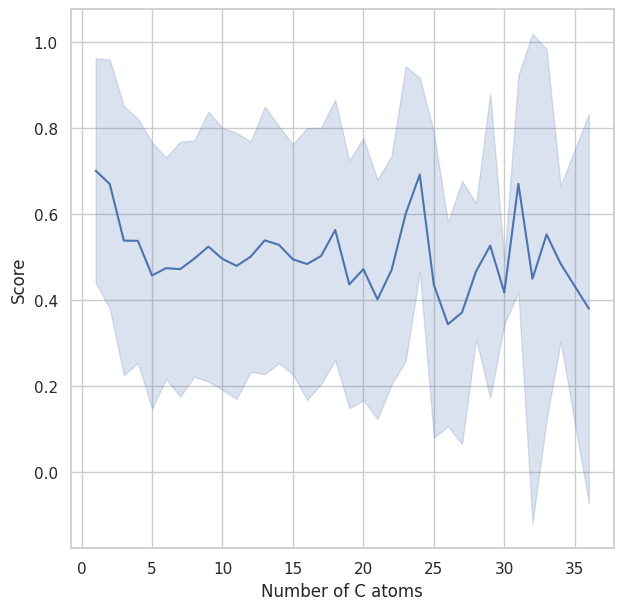

In [15]:
# dummy dataframe for example
test_df = train_df.sample(1000, random_state=42)
test_df['Score'] = np.random.rand(1000)
test_df = test_df[['Drug', 'Score']]


# set figure size
plt.rcParams['figure.figsize'] = [7, 7]
fig1 = plot_atom_number_vs_score(test_df, save_figure_path=None)
